In [11]:
import numpy as np
import matplotlib.pyplot as plt
import prisoner_dilemma as prd
import strategies as strat
import sys

# Strategies 
Importing relevant strategies from the strategies.py module and creating the combinaton array to iterate over for the competition

In [12]:
strat_list = np.array([strat.e4e, strat.random, strat.nice, strat.nasty, strat.probing_5, strat.probing_10, strat.grudge_5, strat.grudge_10, strat.nice_e2e])

# Competition

## General competition parameters
as per basic_competition.ipynb

In [3]:
sigma_rr = 10 # sigma_randomRounds
nrounds = 200 # numRounds
rep = 5 # repetitions

## Parameter exploration



### Grudge
We vary the parameter regulating how long a strategy will keep a grudge against another strategy. \\
Exploration on the parameter of $\texttt{grudge\_x}$

In [4]:
grudge_cust = prd.Strategy("grudge_cust", strat.grudge_af, action_func_parameters={"memory": 10})

memory_min = 1
memory_max = 200
memory_steps = 200
memory_values = np.linspace(memory_min, memory_max, memory_steps, dtype = int)

results = np.zeros(memory_steps)
counter = 0

for memory_val in memory_values: 
    grudge_cust.edit_af_params({"memory": memory_val})
    mod_strat_list = np.append(strat_list, np.array([grudge_cust]))
    mod_strat_comb = np.transpose(np.vstack((np.tile(mod_strat_list, np.size(mod_strat_list)), np.repeat(mod_strat_list, np.size(mod_strat_list)))))

    for pairs in mod_strat_comb:
        current_match = prd.Match(pairs[0], pairs[1])
        current_match.play()
        current_scores = current_match.avgscore()
        if pairs[0].name == "grudge_cust":
            results[counter] += current_scores[0] / current_match.numRounds[0]
        if pairs[1].name == "grudge_cust":
            results[counter] += current_scores[1] / current_match.numRounds[0]

    counter += 1
    sys.stdout.write(f"step: {counter} of {memory_steps}\r")
    sys.stdout.flush()

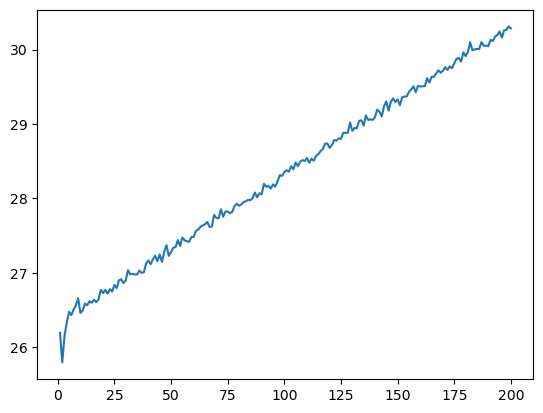

In [5]:
# plotting the result 
fig, ax = plt.subplots()
ax.plot(memory_values,results)
plt.show()

This result is in line with literature, that indeed states how nicer algorithms tend to perform better (remember how at short memory $\texttt{grudge}$ resembles $\texttt{e4e}$ which should be more or less the optimal solution) 

### Retalliation probability 
We explore the model probret, which works similarly to $\texttt{e4e}$ but only retalliates with a certain probability $P$. Note how as $P \rightarrow 1$ $\texttt{probret} \rightarrow \texttt{e4e}$ while as $P \rightarrow 0$ $\texttt{probret} \rightarrow \texttt{nice}$

In [7]:
probret_min = 0
probret_max = 1
probret_steps = 50 
probret_values = np.linspace(probret_min, probret_max, probret_steps, dtype = int)
results = np.zeros(probret_steps)
counter = 0

def probret_af(prevActions: np.array, prob_val = 0.5):
    if(np.size(prevActions) == 0):
        return np.array([1])
    else: 
        if prevActions[1, -1] == 0:
            if np.random.rand(1)[0] < prob_val:
                return np.array([0])
        return np.array([1])

probret = prd.Strategy("probret", probret_af, action_func_parameters={"prob_val": 0.5})

for prob_val in probret_values: 
    probret.edit_af_params({"prob_val": prob_val})
    mod_strat_list = np.append(strat_list, np.array([probret]))
    mod_strat_comb = np.transpose(np.vstack((np.tile(mod_strat_list, np.size(mod_strat_list)), np.repeat(mod_strat_list, np.size(mod_strat_list)))))
    for pairs in mod_strat_comb:
        current_match = prd.Match(pairs[0], pairs[1])
        current_match.play()
        current_scores = current_match.avgscore()
        if pairs[0].name == "probret":
            results[counter] += current_scores[0] / current_match.numRounds[0]
        if pairs[1].name == "probret":
            results[counter] += current_scores[1] / current_match.numRounds[0]
    counter += 1
    sys.stdout.write(f"step: {counter} of {probret_steps}\r")
    sys.stdout.flush()

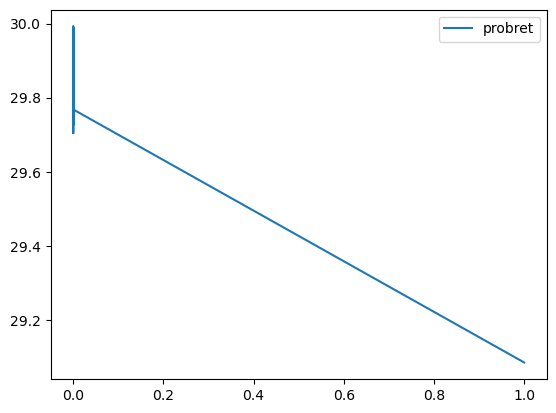

In [8]:
# plotting the result 
fig, ax = plt.subplots()
ax.plot(probret_values,results, label = "probret")
ax.legend()
plt.show()

Note how the performance decreases as the strategy gets less and less retalliatory. This is in line with the consesus that powerful strategies should be retalliatory

### More general problem 
By following the same logic we aim to produce a strategy depending on one parameter (ideally) that as the parameters varies should resemble the $\texttt{nasty}, \texttt{e4e}, \texttt{nice}$ strategies. \\
This would allow to find optimal value of the parameter (also as the scoring points vary eventually)

In [21]:
def sweep_af(prevActions: np.array, u: float = 0):
    if np.size(prevActions) == 0:
        return np.array([1])
    else:
        if u < 0:
            defect_positions = np.where(prevActions[1] == 0)
            if np.size(defect_positions) == 0:
                return np.array([1])
            else:
                last_defect_dist = - np.shape(prevActions)[1] + np.max(defect_positions)
                defect_prob = 1/(1+np.exp(-10*(last_defect_dist-u)))
                if np.random.rand(1)[0] < defect_prob:
                    return np.array([0])
                else:
                    return np.array([1])
        elif u > 0:
            defect_prob = 1/(1+np.exp(10*(1-u)))
            if np.random.rand(1)[0] < defect_prob:
                return np.array([0])
            else:
                return np.array([1])
        else: 
            return np.array([1])

sweep = prd.Strategy("sweep", sweep_af, action_func_parameters={"u": 0})

umin = -50
umax = 2
usteps = 100
u_values = np.linspace(umin, umax, usteps, dtype = float)
results = np.zeros(usteps)

counter = 0
for uval in u_values:
    sweep.edit_af_params({"u": uval})
    mod_strat_list = np.append(strat_list, np.array([sweep]))
    mod_strat_comb = np.transpose(np.vstack((np.tile(mod_strat_list, np.size(mod_strat_list)), np.repeat(mod_strat_list, np.size(mod_strat_list)))))
    for pairs in mod_strat_comb:
        current_match = prd.Match(pairs[0], pairs[1])
        current_match.play()
        current_scores = current_match.avgscore()
        if pairs[0].name == "sweep":
            results[counter] += current_scores[0] / current_match.numRounds[0]
        if pairs[1].name == "sweep":
            results[counter] += current_scores[1] / current_match.numRounds[0]
    counter += 1
    sys.stdout.write(f"step: {counter} of {usteps}\r")
    sys.stdout.flush()


KeyboardInterrupt: 

In [ ]:
# plotting the result
fig, ax = plt.subplots()
ax.plot(u_values,results, label = "sweep")
ax.legend()
plt.show()

In [6]:
def test(a):
    print(a)
    return 0

In [9]:
d = {"a": 10}
test(**d)

TypeError: test() got an unexpected keyword argument 'b'